# DeepTraSynergy Toxicity Score Analysis #
- DeepTraSynergy paper can be found: https://academic.oup.com/bioinformatics/article/39/8/btad438/7226508

In [1]:
# Import everything needed
from matplotlib.patches import Patch
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from scipy import stats
from statsmodels.stats.multitest import multipletests
from toxicity_ranking import *
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import seaborn as sns

DeepTraSynergy creates toxicity score embeddings by:
1. PPIN representation
2. SMILES representations
3. Creating a similarity score by computing inner product of drug embeddings

So let's examine now how well SMILES representation similarity scores would work as a potential toxicity score. How well does SMILES similarity differentiate between toxicity category distributions (Kruskal Wallis) and is there a relationship between SMILES similarity and toxicity (Jonckheere Terpestra Test)

In [2]:
drug_combos_df = pd.read_csv('data_processed/filtered_combos_syntox_known_targallpw.csv')
drug_combos_df

,drug_row,drug_col,cell_line_name,synergy_zip,synergy_loewe,synergy_bliss,synergy_hsa,toxicity_category
0,mefloquine,tamoxifen,TC-32,19.667559,2.263512,25.542924,2.896978,Moderate
1,chloroquine,tamoxifen,TC-32,8.836970,-0.671750,11.944238,-0.517536,Major
2,prochlorperazine,tamoxifen,TC-32,12.411371,1.358891,14.291624,0.880952,Moderate
3,fingolimod,tamoxifen,TC-32,8.007900,-0.764699,5.141360,-0.060902,Major
4,dasatinib,tamoxifen,TC-32,-9.601561,0.314544,-5.351887,0.710809,Moderate
...,...,...,...,...,...,...,...,...
32054,sunitinib,nilutamide,CBRC058,10.012172,7.477252,-6.487555,-8.811142,Moderate
32055,sunitinib,midostaurin,CBRC058,-15.618223,-46.106561,-80.053050,-73.693958,Moderate
32056,vincristine,midostaurin,CBRC058,10.768074,5.982307,8.609542,3.406801,Moderate
32057,ceritinib,ponatinib,RD,11.951861,-2.135860,11.637520,-1.042661,Major


There are SMILES strings in the DrugBank csv file. Collect all of the SMILES and then convert to Morgan Fingerprints, then compute the Tanimoto coefficient for drug combinatoins 

In [3]:
unique_drugs = set(drug_combos_df['drug_row'].unique())
unique_drugs = unique_drugs.union(set(drug_combos_df['drug_col'].unique()))
print(len(unique_drugs))

drugbank_df = pd.read_csv('data_processed/drugbank_drug_targets.csv')
# lowercase the drug names
drugbank_df['drug_name'] = drugbank_df['drug_name'].str.lower()
drugbank_df.dropna(subset=['SMILES'], inplace=True)

# get the SMILES for the unique_drugs
unique_drugcombo_drugs_to_smiles = {}
drugs_with_no_smiles = []
for drug in unique_drugs:
    try:
        smiles = drugbank_df[drugbank_df['drug_name'] == drug]['SMILES'].values[0]
        if smiles == 'nan' or smiles is None or smiles == np.nan:
            drugs_with_no_smiles.append(drug)
        else:
            unique_drugcombo_drugs_to_smiles[drug] = smiles
    except:
        drugs_with_no_smiles.append(drug)

print("Number of unique drugs with SMILES: ")
print(len(unique_drugcombo_drugs_to_smiles))
print("Unique drugs without SMILES: ")
print(drugs_with_no_smiles)

# Manually found remaining SMILES via PubChem website ie https://pubchem.ncbi.nlm.nih.gov/compound/Ixazomib
unique_drugcombo_drugs_to_smiles['lumefantrine'] = 'CCCCN(CCCC)CC(O)c1cc(Cl)cc2\C(=C/c3ccc(Cl)cc3)c3cc(Cl)ccc3-c12' # https://www.ebi.ac.uk/chebi/searchId.do?chebiId=156095
unique_drugcombo_drugs_to_smiles['metaxalone'] = 'CC1=CC(=CC(=C1)OCC2CNC(=O)O2)C'
unique_drugcombo_drugs_to_smiles['eptifibatide'] = 'C1C[C@H]2C(=O)N[C@@H](CSSCCC(=O)N[C@H](C(=O)NCC(=O)N[C@H](C(=O)N[C@H](C(=O)N2C1)CC3=CNC4=CC=CC=C43)CC(=O)O)CCCCN=C(N)N)C(=O)N'
unique_drugcombo_drugs_to_smiles['trimethobenzamide'] = 'CN(C)CCOC1=CC=C(C=C1)CNC(=O)C2=CC(=C(C(=C2)OC)OC)OC'
unique_drugcombo_drugs_to_smiles['ivermectin'] = 'COC1CC(OC2C(C)C=CC=C3COC4C3(O)C(C=C(C4O)C)C(=O)OC3CC(CC=C2C)OC2(C3)CCC(C(O2)C(CC)C)C)OC(C1OC1CC(OC)C(C(O1)C)O)C'
unique_drugcombo_drugs_to_smiles['artemether'] = 'C[C@@H]1CC[C@H]2[C@H]([C@H](O[C@H]3[C@@]24[C@H]1CC[C@](O3)(OO4)C)OC)C'
unique_drugcombo_drugs_to_smiles['ixazomib'] = 'B([C@H](CC(C)C)NC(=O)CNC(=O)C1=C(C=CC(=C1)Cl)Cl)(O)O'


print(unique_drugcombo_drugs_to_smiles)

362
Number of unique drugs with SMILES: 
355
Unique drugs without SMILES: 
['artemether', 'ixazomib', 'metaxalone', 'trimethobenzamide', 'ivermectin', 'lumefantrine', 'eptifibatide']
{'baclofen': 'NCC(CC(O)=O)C1=CC=C(Cl)C=C1', 'meclofenamic acid': 'CC1=C(Cl)C(NC2=CC=CC=C2C(O)=O)=C(Cl)C=C1', 'tacrine': 'NC1=C2CCCCC2=NC2=CC=CC=C12', 'diphenhydramine': 'CN(C)CCOC(C1=CC=CC=C1)C1=CC=CC=C1', 'ranolazine': 'COC1=CC=CC=C1OCC(O)CN1CCN(CC(=O)NC2=C(C)C=CC=C2C)CC1', 'ibuprofen': 'CC(C)CC1=CC=C(C=C1)C(C)C(O)=O', 'pemetrexed': 'NC1=NC(=O)C2=C(NC=C2CCC2=CC=C(C=C2)C(=O)N[C@@H](CCC(O)=O)C(O)=O)N1', 'primidone': 'CCC1(C(=O)NCNC1=O)C1=CC=CC=C1', 'anastrozole': 'CC(C)(C#N)C1=CC(=CC(CN2C=NC=N2)=C1)C(C)(C)C#N', 'efavirenz': 'FC(F)(F)[C@]1(OC(=O)NC2=C1C=C(Cl)C=C2)C#CC1CC1', 'albendazole': 'CCCSC1=CC2=C(C=C1)N=C(NC(=O)OC)N2', 'allopurinol': 'OC1=NC=NC2=C1C=NN2', 'sulfinpyrazone': 'O=C1C(CCS(=O)C2=CC=CC=C2)C(=O)N(N1C1=CC=CC=C1)C1=CC=CC=C1', 'ibrutinib': 'NC1=NC=NC2=C1C(=NN2[C@@H]1CCCN(C1)C(=O)C=C)C1=CC=C(OC2=C

In [4]:
# Get the morgan fingerprints for the unique_drugs
unique_drugcombo_drugs_to_morgan_fp = {}
for drug in unique_drugcombo_drugs_to_smiles:
    mol = Chem.MolFromSmiles(unique_drugcombo_drugs_to_smiles[drug])
    if mol is None:
        print("Error with drug: " + drug)
        continue
    else:
        morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        unique_drugcombo_drugs_to_morgan_fp[drug] = morgan_fp

# Are there any drugs without a fingerprint?
drugs_without_fp = []
for drug in unique_drugcombo_drugs_to_morgan_fp:
    if np.array(unique_drugcombo_drugs_to_morgan_fp[drug]).sum() == 0:
        drugs_without_fp.append(drug)
print("Drugs without a fingerprint: ")
print(drugs_without_fp)

# For each drug combination in drug_combos_df, calculate the Tanimoto similarity between the two drugs
drug_combos_df['tanimoto_similarity'] = np.nan
for index, row in drug_combos_df.iterrows():
    drug_row = row['drug_row']
    drug_col = row['drug_col']
    morgan_fp_row = unique_drugcombo_drugs_to_morgan_fp[drug_row]
    morgan_fp_col = unique_drugcombo_drugs_to_morgan_fp[drug_col]
    tanimoto_similarity = DataStructs.TanimotoSimilarity(morgan_fp_row, morgan_fp_col)
    drug_combos_df.at[index, 'tanimoto_similarity'] = tanimoto_similarity

# Are there any drug combinations without a Tanimoto similarity?
print(len(drug_combos_df[drug_combos_df['tanimoto_similarity'].isnull()]))

Drugs without a fingerprint: 
[]
0


(array([1.4360e+03, 1.0924e+04, 1.2704e+04, 4.5860e+03, 1.2780e+03,
        7.9000e+01, 4.3700e+02, 1.0200e+02, 1.6500e+02, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 1.1500e+02, 0.0000e+00, 0.0000e+00,
        5.7000e+01, 6.0000e+01, 5.2000e+01, 6.0000e+01, 1.0000e+00]),
 array([0.   , 0.043, 0.086, 0.129, 0.172, 0.215, 0.258, 0.301, 0.344,
        0.387, 0.43 , 0.473, 0.516, 0.559, 0.602, 0.645, 0.688, 0.731,
        0.774, 0.817, 0.86 ]),
 <BarContainer object of 20 artists>)

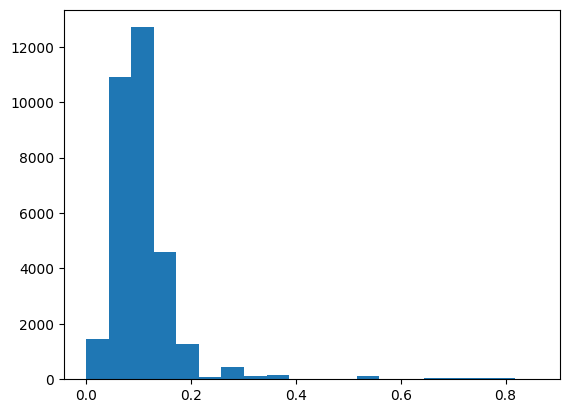

In [5]:
# Look at histogram of Tanimoto similarities
plt.hist(drug_combos_df['tanimoto_similarity'], bins=20)

In [6]:
# Run Kruskal Wallis test on tanimoto similarity for Major, Moderate, and Minor toxicity categories

# Tanimoto similarity
major_tanimoto = drug_combos_df[drug_combos_df['toxicity_category'] == 'Major']['tanimoto_similarity'].dropna()
moderate_tanimoto = drug_combos_df[drug_combos_df['toxicity_category'] == 'Moderate']['tanimoto_similarity'].dropna()
minor_tanimoto = drug_combos_df[drug_combos_df['toxicity_category'] == 'Minor']['tanimoto_similarity'].dropna()
print(f'Major tanimoto: {len(major_tanimoto)}')
print(f'Moderate tanimoto: {len(moderate_tanimoto)}')
print(f'Minor tanimoto: {len(minor_tanimoto)}')

h_statistic_tanimoto_tox, p_value_tanimoto_tox = stats.kruskal(major_tanimoto, moderate_tanimoto, minor_tanimoto)
print(f'Kruskal-Wallis H statistic for tanimoto similarity: {h_statistic_tanimoto_tox}')
print(f'P-value for tanimoto similarity: {p_value_tanimoto_tox}')

dunn_tanimoto_tox = sp.posthoc_dunn(drug_combos_df, val_col='tanimoto_similarity', group_col='toxicity_category', p_adjust='bonferroni')
print('Dunn post-hoc test for tanimoto similarity:' + str(dunn_tanimoto_tox))

tanimoto_major_samples = major_tanimoto.values.tolist()
tanimoto_moderate_samples = moderate_tanimoto.values.tolist()
tanimoto_minor_samples = minor_tanimoto.values.tolist()
jt_incr_tanimoto = jonckheere_terpestra_test([tanimoto_minor_samples, tanimoto_moderate_samples, tanimoto_major_samples])
print("Increasing toxicity for Tanimoto similarity: ", jt_incr_tanimoto )
jt_decr_tanimoto = jonckheere_terpestra_test([tanimoto_major_samples, tanimoto_moderate_samples, tanimoto_minor_samples])
print("Decreasing toxicity for Tanimoto similarity: ", jt_decr_tanimoto)

# Run an ANOVA on tanimoto similarity for Major, Moderate, and Minor toxicity categories
f_statistic_anova_tanimoto_tox, p_value_anova_tanimoto_tox = stats.f_oneway(major_tanimoto, moderate_tanimoto, minor_tanimoto)
print(f'ANOVA F-statistic for tanimoto similarity: {f_statistic_anova_tanimoto_tox}')
print(f'P-value for tanimoto similarity: {p_value_anova_tanimoto_tox}')

# Run a T test on tanimoto similarity between Major/Minor, Major/Moderate, and Moderate/Minor toxicity categories
major_minor_tanimoto = stats.ttest_ind(major_tanimoto, minor_tanimoto)
major_moderate_tanimoto = stats.ttest_ind(major_tanimoto, moderate_tanimoto)
moderate_minor_tanimoto = stats.ttest_ind(moderate_tanimoto, minor_tanimoto)

# Run bonferroni correction on the p-values
ttest_p_values = [major_minor_tanimoto[1], major_moderate_tanimoto[1], moderate_minor_tanimoto[1]]
ttest_p_values_corrected = multipletests(ttest_p_values, method='bonferroni')
print(f'Major/Minor T-test: {major_minor_tanimoto[1]} Corrected: {ttest_p_values_corrected[1][0]}')
print(f'Major/Moderate T-test: {major_moderate_tanimoto[1]} Corrected: {ttest_p_values_corrected[1][1]}')
print(f'Moderate/Minor T-test: {moderate_minor_tanimoto[1]} Corrected: {ttest_p_values_corrected[1][2]}')

with open('results/jaccard_similarity_analysis/mfp_tox_tanimoto_ddinter.tsv', 'w') as f:
    f.write('Level\tTest\tTest statistic\tP-value\n')
    f.write(f'MFP\tKruskal-Wallis\t{h_statistic_tanimoto_tox}\t{p_value_tanimoto_tox}\n')
    f.write(f'MFP\tDunn post-hoc\tMajor/Minor\t{dunn_tanimoto_tox.iloc[0, 1]}\n')
    f.write(f'MFP\tDunn post-hoc\tMajor/Moderate\t{dunn_tanimoto_tox.iloc[0, 2]}\n')
    f.write(f'MFP\tDunn post-hoc\tModerate/Minor\t{dunn_tanimoto_tox.iloc[1, 2]}\n')
    f.write(f'MFP\tJonckheere-Terpstra Increasing toxicity\t{jt_incr_tanimoto[0]}\t{jt_incr_tanimoto[1]}\n')
    f.write(f'MFP\tJonckheere-Terpstra Decreasing toxicity\t{jt_decr_tanimoto[0]}\t{jt_decr_tanimoto[1]}\n')
    f.write(f'MFP\tANOVA\t{f_statistic_anova_tanimoto_tox}\t{p_value_anova_tanimoto_tox}\n')
    f.write(f'MFP\tT-test\tMajor/Minor\t{ttest_p_values_corrected[1][0]}\n')
    f.write(f'MFP\tT-test\tMajor/Moderate\t{ttest_p_values_corrected[1][1]}\n')
    f.write(f'MFP\tT-test\tModerate/Minor\t{ttest_p_values_corrected[1][2]}\n')

Major tanimoto: 6091
Moderate tanimoto: 25092
Minor tanimoto: 876
Kruskal-Wallis H statistic for tanimoto similarity: 142.7951830053862
P-value for tanimoto similarity: 9.826978122528683e-32
Dunn post-hoc test for tanimoto similarity:                 Major         Minor      Moderate
Major     1.000000e+00  1.247274e-05  7.384942e-19
Minor     1.247274e-05  1.000000e+00  2.954570e-17
Moderate  7.384942e-19  2.954570e-17  1.000000e+00
Increasing toxicity for Tanimoto similarity:  (5.065979073646385, 2.0315327631248437e-07)
Decreasing toxicity for Tanimoto similarity:  (-5.065979073646385, 0.9999997968467237)
ANOVA F-statistic for tanimoto similarity: 7.60115842414952
P-value for tanimoto similarity: 0.0005007735286495375
Major/Minor T-test: 0.02800697780221626 Corrected: 0.08402093340664879
Major/Moderate T-test: 0.0001156626683303349 Corrected: 0.0003469880049910047
Moderate/Minor T-test: 0.7886832540027575 Corrected: 1.0


In [7]:
colors = ['#20965D', '#FFBC42', '#D81159']
tox_order = ['Minor', 'Moderate', 'Major']
color_dict = dict(zip(tox_order, colors))
legend_elements = [
    Patch(facecolor=color_dict[cat], label = cat) for cat in tox_order
]

ax = sns.violinplot(data=drug_combos_df, x='toxicity_category', y='tanimoto_similarity', palette=color_dict, hue='toxicity_category', order=tox_order)
ax.set_xlabel('')
ax.set_ylabel('Drug Morgan Fingerprints Tanimoto Similarity')
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5,-0.2), loc='center', ncol=3)
plt.tight_layout()
plt.savefig('results/smiles/drugmfpts_v_toxcats_ddinter_violin.png', dpi=700)
plt.close()

In [ ]:
ax = sns.stripplot(data=drug_combos_df, x='toxicity_category', y='tanimoto_similarity', palette=color_dict, hue='toxicity_category', order=tox_order)
ax.set_xlabel('')
ax.set_ylabel('Drug Morgan Fingerprints Tanimoto Similarity')
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5,-0.2), loc='center', ncol=3)
plt.tight_layout()
plt.savefig('results/smiles/drugmfpts_v_toxcats_ddinter_strip.png', dpi=700)
plt.close()